# Data analysis

This notebook consist of analysis of collected data. The reason of such analysis is to get some insights on what format and type of values are there, deciding on what fields can be removed (for example when they are to noisy) and what can be useful for classification task. Also some preprocessing of those fields can be done here, in case there is a need to change the type of variable etc. 
This part is complementary with the notebook "Data on maps".  

In [1]:
from IPython.display import clear_output
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data loading and preparation

Read the data from database and prepare for analysis

In [5]:
db_client = MongoClient('localhost', 27017)
db = db_client.musicdata
spotify_artist_collection = db.get_collection('spotify_artist_albums')
mb_artist_collection = db.get_collection('artists_mb')
wikidata_artist_collection = db.get_collection('artist_wikidata')

In [6]:
#how many artists in spotify collection have mb_id?
mb_ids_number = spotify_artist_collection.find({'mb_id': {'$exists': True}}).count()
print(mb_ids_number)

739298


In [7]:
#load data from mongo database to dataframe
cursor = spotify_artist_collection.find({'mb_id': {'$exists': True}}, {'albums':0, 'mb_info':0, 'mb_name': 0})

df = pd.DataFrame(list(cursor))

In [8]:
#change format of artist followers from dict to single value
df.loc[:, 'followers'] = df.followers.apply(lambda x: x["total"] if type(x) == dict else 0)

In [9]:
df.dtypes

_id            object
followers     float64
genres         object
mb_id          object
name           object
popularity    float64
dtype: object

In [10]:
df.head(5)

,_id,followers,genres,mb_id,name,popularity
0,3XSyTI9ct70ZheMESAv2st,3752.0,[broadway],290e5513-55d3-426f-a4ba-1ac3ce589107,Zachary Levi,61.0
1,2jYHSJBXjusgmYdrNeaRmg,1361.0,"[jazz guitar, smooth jazz]",09cddf26-fe4a-493e-bb1d-64723892ed8d,Zachary Breaux,29.0
2,5LmehwqsJa7a4Ya5SaqXpx,1147.0,[doo-wop],ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,The Silhouettes,37.0
3,10BFTSAfLauhKVmdby4zac,0.0,[],3a8ecc10-f888-48c0-9674-5c0ccd1fe93f,Peter & the Silhouettes,0.0
4,4hwEAtCJZa1LMgbuRpUWJB,4.0,[],ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,The Lost Silhouettes,0.0


## Data analysis

### Popularity

Popularity is a value defined by Spotify. The range of this value is between 0 and 100, and according to Spotify it is determined based on the number of times the artist's songs was played, number of followers. What is important is that recent plays are more valuable than older ones, so artists with newer songs will probably be more popular than some artists that were popular few years ago.  

After first look, it turned out that the number of artists with popularity 0 is so big, that after plotting the histogram none of the other values were visible. This is why artists with popularity 0 are ommited in this plot.

In [11]:
#find popularity frequency
freq = df.groupby('popularity').count()
print(freq)

               _id  followers  genres   mb_id    name
popularity                                           
0.0         334234     334209  334234  334234  334234
1.0          63045      63040   63045   63045   63045
2.0          37792      37789   37792   37792   37792
3.0          27705      27704   27705   27705   27705
4.0          22249      22249   22249   22249   22249
5.0          18584      18583   18584   18584   18584
6.0          15898      15897   15898   15898   15898
7.0          13920      13920   13920   13920   13920
8.0          12353      12353   12353   12353   12353
9.0          11264      11263   11264   11264   11264
10.0         10137      10137   10137   10137   10137
11.0          9382       9382    9382    9382    9382
12.0          8583       8583    8583    8583    8583
13.0          8049       8047    8049    8049    8049
14.0          7623       7621    7623    7623    7623
15.0          7014       7013    7014    7014    7014
16.0          6849       684

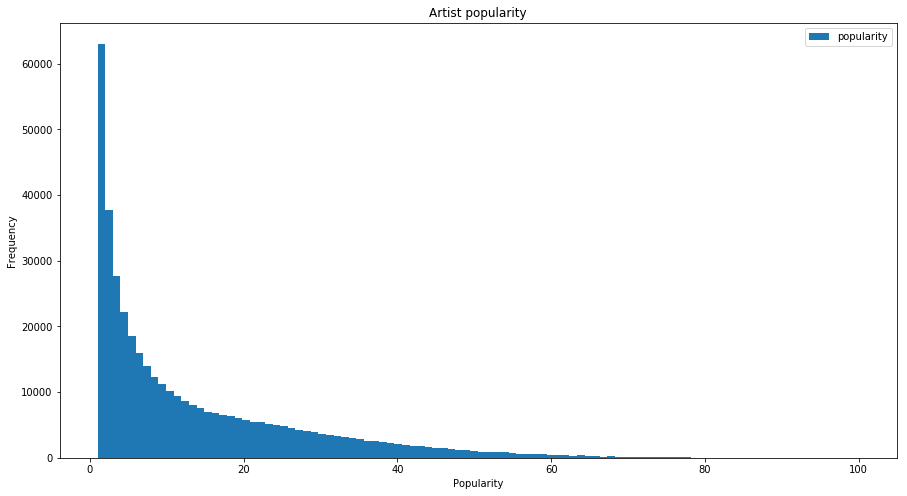

In [12]:
df_popularity = df[df.popularity != 0]
df_popularity.plot.hist(y='popularity', bins=100, figsize=(15,8), title ="Artist popularity")
plt.xlabel("Popularity")
plt.savefig("figures/artist_popularity.png")

### Followers

The number of people that decided to 'follow' that artist.

In [13]:
df_followers = df[df.followers > 100]

In [14]:
df_followers.describe()

,followers,popularity
count,1.942200e+05,194220.000000
mean,1.689932e+04,20.959984
std,1.966596e+05,15.861348
min,1.010000e+02,0.000000
25%,2.100000e+02,8.000000
50%,5.460000e+02,18.000000
75%,2.277000e+03,31.000000
max,2.052686e+07,100.000000


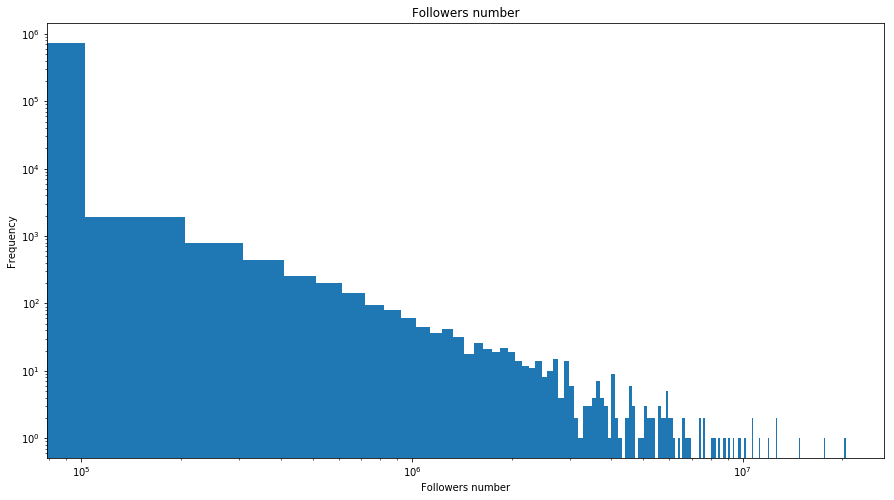

In [16]:
df.followers.plot.hist(y='followers', bins=200, figsize=(15,8), title="Followers number")
plt.xlabel("Followers number")
plt.yscale("log")
plt.xscale("log")
plt.savefig("figures/followers.png")

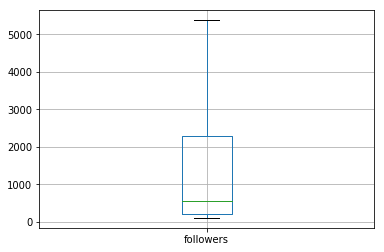

In [14]:
df_followers.boxplot(column='followers', showfliers=False)

### Popularity and followers
 By intuition those values should be highly correlated, especially that number of followers is one of the factors in computing artist popularity.


In [30]:
#remove artists with 0 followers and 0 popularity
df_fp = df[df['followers']>0]
df_fp = df_fp[df_fp['popularity']>0]
df_fp['followers'].corr(df_fp['popularity'])

0.22533318858212736

The value 0.23 means very weak positive correlation. Althought the trend in both variables is similar they are not well correlated.

### Music genres

Music genres were taken from Spotify dataset and they are defined by artists themselves, which means that there is no bounded set of possible values for that variable. The goal is to check number of genres, their frequency and based on those values reduce this number by merging similar genres and removing the least popular ones. 

In [70]:
genres = df.genres.tolist()
cleaned = [x for x in genres if str(x) != 'nan']
flat_genres = [item for sublist in cleaned for item in sublist]

In [71]:
unique, counts = np.unique(flat_genres, return_counts=True)
genres_frequency = dict(zip(unique, counts))

In [72]:

print(len(genres_frequency))

1634


In [73]:
#Set of all genres with their frequencies
import operator
sorted_freq = sorted(genres_frequency.items(), key=operator.itemgetter(1))
print(sorted_freq)

[('albanian hip hop', 1), ('argentine hip hop', 1), ('azeri traditional', 1), ('balkan hip hop', 1), ('chilean indie', 1), ('chinese opera', 1), ('classic cantopop', 1), ('estonian hip hop', 1), ('hard bass', 1), ('hindustani instrumental', 1), ('indie pop rap', 1), ('italian alternative', 1), ('jazz clarinet', 1), ('keroncong', 1), ('metal noir quebecois', 1), ('oriental metal', 1), ('peruvian hip hop', 1), ('recorder', 1), ('rock quebecois', 1), ('sertanejo pop', 1), ('sitar', 1), ('south african pop', 1), ('spanish comedy', 1), ('sung poetry', 1), ('vogue', 1), ('australian garage punk', 2), ('azeri pop', 2), ('brazilian metal', 2), ('cumbia salvadorena', 2), ('german jazz', 2), ('indie quebecois', 2), ('latin ska', 2), ('lo-fi beats', 2), ('lo-fi house', 2), ('maltese pop', 2), ('rock chapin', 2), ('rock kapak', 2), ('romanian hip hop', 2), ('streektaal', 2), ('venezuelan hip hop', 2), ('arabic hip hop', 3), ('bongo flava', 3), ('brazilian reggae', 3), ('brazilian rock', 3), ('colo

In [74]:
#reduce number of categories by combining them into groups
categories_names = ["pop", "rock", "hip hop", "rap", "soul", "christmas", "jazz", "opera", "electro",
                    "techno", "metal", "country", "reggae", "blues", "classical", "punk", "folk", "disco",
                   "funk", "r&b", "house", "indie", "latin", "christian", "hardcore", "dance", "trance", 
                   "bass", "contemporary", "dubstep", "psych", "alternative", "electro", "new age", "chill",
                   "swing", "ragga", "death"]
categories_dict = {}
not_classified = [cat for cat in sorted_freq]

for n in categories_names:
    categories_dict[n] = []

In [75]:
for category in categories_names:
    for genre in sorted_freq:
        if category in genre[0]:
            categories_dict[category].append(genre[0])
            if genre in not_classified:
                not_classified.remove(genre)
    

In [76]:
print(len(not_classified))
print(not_classified)

612
[('azeri traditional', 1), ('hindustani instrumental', 1), ('keroncong', 1), ('recorder', 1), ('sitar', 1), ('spanish comedy', 1), ('sung poetry', 1), ('vogue', 1), ('cumbia salvadorena', 2), ('lo-fi beats', 2), ('streektaal', 2), ('bongo flava', 3), ('islamic recitation', 3), ('kayokyoku', 4), ('sleep', 6), ('cornetas y tambores', 7), ('football', 8), ('villancicos', 10), ('enka', 11), ('fussball', 11), ('orquesta tropical', 11), ('tanzlmusi', 12), ('workout', 12), ('world meditation', 12), ('entehno', 14), ('mantra', 14), ('laiko', 16), ('prank', 17), ('punta', 17), ('rebetiko', 17), ('tribute', 17), ('halloween', 18), ('deep norteno', 19), ('nepali', 19), ('byzantine', 20), ('musica per bambini', 20), ('anime score', 21), ('kuduro', 22), ('deep filthstep', 23), ('tibetan', 24), ('beats', 26), ('college marching band', 26), ('environmental', 26), ('liturgical', 26), ('panpipe', 26), ('spoken word', 26), ('capoeira', 27), ('chinese minyao', 27), ('nasheed', 27), ('steelpan', 27), 

In [77]:
categories_dict["kids music"] = ["musique pour enfants", "kindermusik", "disney", "musica per bambini",
                                "muziek voor kinderen"]
categories_dict["reggae"].append("ragga")
categories_dict["reggae"].append("ragtime")
categories_dict["latin"].append("merengue")
categories_dict["latin"].append("salsa")
categories_dict["latin"].append("rumba")
categories_dict["latin"].append("kizomba")
categories_dict["latin"].append("flamenco")
categories_dict["latin"].append("tropical")
categories_dict["latin"].append("cuban rumba")
categories_dict["latin"].append("salsa international")
categories_dict["latin"].append("tropical")
categories_dict["latin"].append("cuduro")
categories_dict["latin"].append("hawaiian")
categories_dict["latin"].append("beach music")
categories_dict["electro"].append("edm")


for g in not_classified:
    if "hop" in g[0]:
        categories_dict["hip hop"].append(g[0])



In [78]:
total = 0
for genre, subgenre in categories_dict.items():
    total += len(subgenre)
    print(genre, len(subgenre))

print(total)

pop 178
rock 150
hip hop 70
rap 31
soul 19
christmas 16
jazz 58
opera 3
electro 55
techno 15
metal 76
country 20
reggae 20
blues 30
classical 22
punk 53
folk 51
disco 12
funk 22
r&b 7
house 45
indie 96
latin 31
christian 15
hardcore 20
dance 20
trance 16
bass 12
contemporary 8
dubstep 6
psych 19
alternative 28
new age 2
chill 12
swing 6
ragga 2
death 15
kids music 5
1266


In [79]:
#add new column with simplified genres to the df

def reduce_genres(genres_list):
    reduced_genres = []
    try:
        for gen in genres_list:
            for category, genres in categories_dict.items():
                if gen in genres:
                    reduced_genres.append(category)
        if len(reduced_genres) == 0:
            return genres_list
        return list(set(reduced_genres))
    except:
        return genres_list

In [80]:
df['reduced_genres'] = df['genres'].apply(reduce_genres)

#### Genres - results

Before the reduction there were 1634 distinct values of genres. Merging the most similar ones was done by combining classes with same names or using knowledge about music genres. For example categories 'pop rock' and 'pop rap' were added to the 'pop' category and 'salsa', 'merengue' to the category 'latin'. After this operation there are about 600 genres left, which is three times less than the original value.|

### Genders
In Musicbrainz database there are three values for artist genders - Male, Female, unknown and few values for the type (Person, Group etc.), only for group 'Person' there is a distinction between genders.  

Analysis has shown that there are much more Male than Female artists (this trend can be seen on the map ....TODO add link), which has to be taken into account for classification tasks.

In [32]:
cursormb = mb_artist_collection.find({}, {'type':1, 'gender':1})

df_mb = pd.DataFrame(list(cursormb))


#### Type of artist

In [36]:
from pandas.plotting import table
df_mb = df_mb[df_mb.type != 'unknown']
type_freq = df_mb.groupby('type').count()
print(type_freq)


              _id  gender
type                     
Character    4660    4660
Choir        4294    4294
Group      312170  312170
Orchestra    4511    4511
Other        1863    1863
Person     685688  685688


#### Gender of artist

In [84]:
gender_freq = df_mb.groupby('gender').count()
print(gender_freq)

            _id    type
gender                 
Female   104242  104242
Male     382694  382694
Other       541     541
unknown  525709  525709


In [85]:
#add genders and types to the dataset
df_mb = df_mb.rename(columns= {'_id': 'mb_id'})

In [86]:
df.head()

,_id,followers,genres,mb_id,name,popularity,reduced_genres
0,3XSyTI9ct70ZheMESAv2st,3752.0,[broadway],290e5513-55d3-426f-a4ba-1ac3ce589107,Zachary Levi,61.0,[broadway]
1,2jYHSJBXjusgmYdrNeaRmg,1361.0,"[jazz guitar, smooth jazz]",09cddf26-fe4a-493e-bb1d-64723892ed8d,Zachary Breaux,29.0,[jazz]
2,5LmehwqsJa7a4Ya5SaqXpx,1147.0,[doo-wop],ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,The Silhouettes,37.0,[doo-wop]
3,10BFTSAfLauhKVmdby4zac,0.0,[],3a8ecc10-f888-48c0-9674-5c0ccd1fe93f,Peter & the Silhouettes,0.0,[]
4,4hwEAtCJZa1LMgbuRpUWJB,4.0,[],ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,The Lost Silhouettes,0.0,[]


In [87]:
df_mb.head()

,mb_id,gender,type
1,49add228-eac5-4de8-836c-d75cde7369c3,unknown,Person
3,ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,unknown,Group
6,3e1bd546-d2a7-49cb-b38d-d70904a1d719,Male,Person
12,4c4b7c6f-9285-4d6a-bc10-e5c9e08045f8,unknown,Group
13,055f435f-dba6-4156-9050-6ac41113e45f,unknown,Group


### Date of the beginning of the career

For one of classification tasks the date of the beginning of the career is needed. In musicbrainz database this value is different for groups, where it means the foundation year (usually first album) and for single artist where it is their birthday.

In [39]:
cursormb_year = mb_artist_collection.find({}, {'begin_date_year':1})
df_dates = pd.DataFrame(list(cursormb_year))
df_dates = df_dates.rename(columns= {'_id': 'mb_id'})

In [40]:
df_dates.head()

,mb_id,begin_date_year
0,8972b1c1-6482-4750-b51f-596d2edea8b1,NaN
1,49add228-eac5-4de8-836c-d75cde7369c3,NaN
2,c112a400-af49-4665-8bba-741531d962a1,NaN
3,ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b,1956.0
4,7b4a548e-a01a-49b7-82e7-b49efeb9732c,NaN


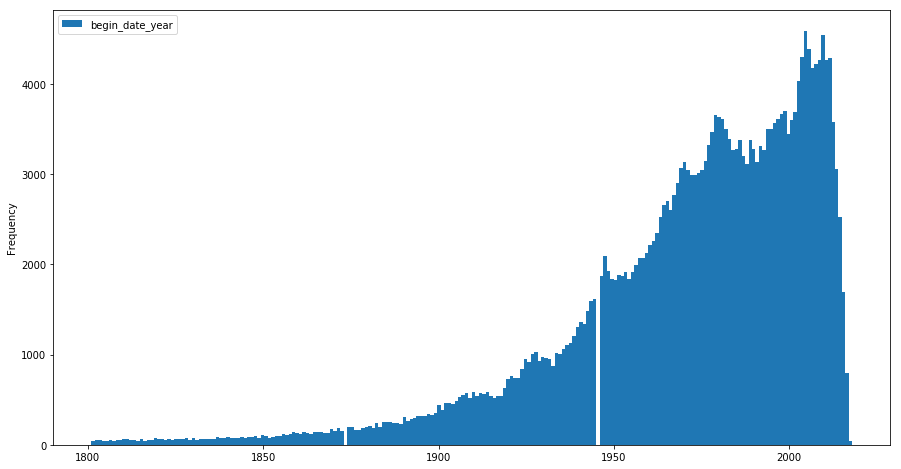

In [41]:
df_dates[(df_dates['begin_date_year']<2020) & (df_dates['begin_date_year']> 1800)].plot.hist(y='begin_date_year', bins=220, figsize=(15,8))

In [43]:
#plot histogram for groups
df_spotify_mb[(df_spotify_mb['type']=='Group') & (df_spotify_mb['begin_date_year']<2020) & (df_spotify_mb['begin_date_year']> 1900)].plot.hist(y='begin_date_year', bins=117, figsize=(15,8))
plt.xlabel("Foundation year")
plt.savefig("figures/groups_foundation.png")

NameError: name 'df_spotify_mb' is not defined

In [ ]:
#plot histogram for single artists
df_spotify_mb[(df_spotify_mb['type']=='Person') & (df_spotify_mb['begin_date_year']<2020) & (df_spotify_mb['begin_date_year']> 1900)].plot.hist(y='begin_date_year', bins=118, figsize=(15,8))

### Merge genders and begin_years with the main dataset

In [100]:
df_spotify_mb = df.merge(df_mb, left_on="mb_id", right_on="mb_id", how="left")

In [101]:
df_spotify_mb = df_spotify_mb.merge(df_dates, how='left', left_on='mb_id', right_on='mb_id')

In [ ]:
df_spotify_mb['age'] = 2018-df_spotify_mb['begin_date_year']

### Save created datased to csv file
 
Since some changes were made in the dataset that will be useful for classification task, it has to be saved for later use.

In [113]:
df_spotify_mb.to_csv("dataset.csv")